# Radar backscatter RGB composites

Since radar data is quite complex to interpret, temporal RGB composites are a nice way to vividly display changes in backscatter over time. *yeoda* is the perfect tool to assist in this use case, since it allows to select and filter data in an interactive and flexible manner. As input we use radiometric terrain-flattened gamma nought data in VV polarisation produced by the GEO Department of TU Wien within the frame of the [ACube](https://acube.eodc.eu/) project. To limit the necessary disk space, this benchmark dataset consists of data from July 2016, July 2018, and July 2021 for a region aroung Lake Neusiedl, Austria. Our aim is now to compute monthly averages for these three years and visualise them as an RGB composite.

Lets start! First, we need to collect all file paths,

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob

ds_path = r"D:\data\code\yeoda\2022_08__docs\radar_data"
filepaths = glob.glob(os.path.join(ds_path, "*.tif"))
filepaths[:10]

['D:\\data\\code\\yeoda\\2022_08__docs\\radar_data\\D20160702_163408--_GMR------_S1AIWGRDH1VVA_175_A0105_EU010M_E053N015T1.tif',
 'D:\\data\\code\\yeoda\\2022_08__docs\\radar_data\\D20160704_050935--_GMR------_S1AIWGRDH1VVD_022_A0105_EU010M_E052N015T1.tif',
 'D:\\data\\code\\yeoda\\2022_08__docs\\radar_data\\D20160704_050935--_GMR------_S1AIWGRDH1VVD_022_A0105_EU010M_E053N015T1.tif',
 'D:\\data\\code\\yeoda\\2022_08__docs\\radar_data\\D20160704_051000--_GMR------_S1AIWGRDH1VVD_022_A0105_EU010M_E052N015T1.tif',
 'D:\\data\\code\\yeoda\\2022_08__docs\\radar_data\\D20160706_045311--_GMR------_S1AIWGRDH1VVD_051_A0105_EU010M_E053N015T1.tif',
 'D:\\data\\code\\yeoda\\2022_08__docs\\radar_data\\D20160706_045336--_GMR------_S1AIWGRDH1VVD_051_A0105_EU010M_E053N015T1.tif',
 'D:\\data\\code\\yeoda\\2022_08__docs\\radar_data\\D20160707_164202--_GMR------_S1AIWGRDH1VVA_073_A0105_EU010M_E052N015T1.tif',
 'D:\\data\\code\\yeoda\\2022_08__docs\\radar_data\\D20160707_164202--_GMR------_S1AIWGRDH1VVA_07

define the dimensions we are interested in and create a `DataCubeReader` instance. The naming convention of ACube data follows the `SgrtFilename` convention, which is already defined in *geopathfinder*.

In [3]:
from yeoda.datacube import DataCubeReader
from geopathfinder.naming_conventions.sgrt_naming import SgrtFilename 

dimensions = ['time', 'tile_name', 'relative_orbit']
dc_reader = DataCubeReader.from_filepaths(filepaths, fn_class=SgrtFilename, dimensions=dimensions,
                                          stack_dimension="time", tile_dimension="tile_name")
dc_reader

DataCubeReader -> GeoTiffReader(time, MosaicGeometry):

                                              filepath   tile_name  \
0    D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
1    D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E052N015T1   
2    D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
3    D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E052N015T1   
4    D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
..                                                 ...         ...   
207  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
208  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E052N015T1   
209  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
210  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
211  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   

     relative_orbit                time  
0               175 2016-07-02 16:34:08  
1                22

To stay within a reasonable time when computing temporal averages, we can pre-filter the datacube per relative orbit first. An appropriate selection would be for instance to take the orbit with the largest file sizes, i.e. containing the largest amount of measurements. To do so, we can add a new dimension to the datacube containing the size in MB for each file. 

In [4]:
file_sizes = [int(os.path.getsize(filepath)/1e6) for filepath in dc_reader['filepath']]
dc_reader.add_dimension("file_size", file_sizes, inplace=True)

DataCubeReader -> GeoTiffReader(time, MosaicGeometry):

                                              filepath   tile_name  \
0    D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
1    D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E052N015T1   
2    D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
3    D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E052N015T1   
4    D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
..                                                 ...         ...   
207  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
208  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E052N015T1   
209  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
210  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   
211  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E053N015T1   

     relative_orbit                time  file_size  
0               175 2016-07-02 16:34:08         95

Now we need to look at each tile separately to check if the relative orbit covers both tiles sufficiently.

In [5]:
dc_reader.select_tiles(["E052N015T1"]).sort_by_dimension("file_size").file_register

,filepath,tile_name,relative_orbit,time,file_size
74,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2018-07-13 05:02:17,4
90,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2018-07-19 05:01:35,4
57,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2018-07-07 05:01:34,4
107,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2018-07-25 05:02:17,4
123,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2018-07-31 05:01:36,4
...,...,...,...,...,...
105,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2018-07-25 05:01:52,184
42,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2018-07-01 05:01:51,184
121,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2018-07-31 05:01:11,185
88,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2018-07-19 05:01:10,185


In [6]:
dc_reader.select_tiles(["E053N015T1"]).sort_by_dimension("file_size").file_register

,filepath,tile_name,relative_orbit,time,file_size
70,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,22,2018-07-12 05:09:10,3
161,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,22,2021-07-14 05:10:11,3
190,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,146,2021-07-22 16:51:10,3
188,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,146,2021-07-22 16:50:45,3
47,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,146,2018-07-02 16:50:25,3
...,...,...,...,...,...
89,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,124,2018-07-19 05:01:10,186
122,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,124,2018-07-31 05:01:11,187
106,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,124,2018-07-25 05:01:52,187
201,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,124,2021-07-27 05:01:34,188


It looks like relative orbit number 124 is a good choice. Thus, we select this relative orbit number in the datacube

In [7]:
dc_reader.select_by_dimension(lambda r: r == 124, name='relative_orbit', inplace=True)
dc_reader.file_register

,filepath,tile_name,relative_orbit,time,file_size
10,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2016-07-11 05:01:25,23
11,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,124,2016-07-11 05:01:25,75
12,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2016-07-11 05:01:50,167
13,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,124,2016-07-11 05:01:50,119
26,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2016-07-23 05:01:36,149
27,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,124,2016-07-23 05:01:36,183
28,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2016-07-23 05:02:01,38
29,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,124,2016-07-23 05:02:01,4
42,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E052N015T1,124,2018-07-01 05:01:51,184
43,D:\data\code\yeoda\2022_08__docs\radar_data\D2...,E053N015T1,124,2018-07-01 05:01:51,186


define a bounding box covering the southern part of Lake Neusiedl,

<GeoAxesSubplot:>

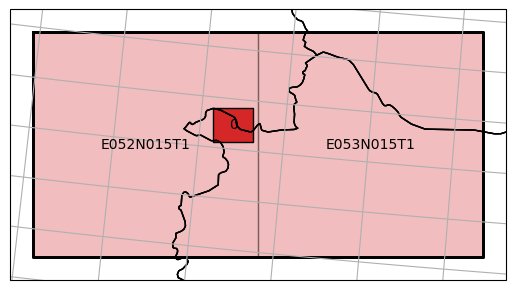

In [8]:
bbox = [(5280269, 1551367), (5297621, 1566199)]
dc_reader.select_bbox(bbox, inplace=True)

plot_extent = dc_reader.mosaic.parent_root.outer_extent
extent_bfr = 10e3
plot_extent = [plot_extent[0] - extent_bfr, plot_extent[1] - extent_bfr, 
               plot_extent[2] + extent_bfr, plot_extent[3] + extent_bfr]
ax = dc_reader.mosaic.parent_root.plot(label_tiles=True, extent=plot_extent, alpha=0.3)
dc_reader.mosaic.plot(label_tiles=True, ax=ax, extent=plot_extent)

split the data temporally to have a datacube for each month/year, 

In [9]:
dc_months = dc_reader.split_by_temporal_freq('Y')
dc_months[0]

DataCubeReader -> GeoTiffReader(time, MosaicGeometry):

                                             filepath   tile_name  \
10  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E052N015T1   
12  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E052N015T1   
26  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E052N015T1   
28  D:\data\code\yeoda\2022_08__docs\radar_data\D2...  E052N015T1   

    relative_orbit                time  file_size  
10             124 2016-07-11 05:01:25         23  
12             124 2016-07-11 05:01:50        167  
26             124 2016-07-23 05:01:36        149  
28             124 2016-07-23 05:02:01         38  

and finally read the data, decode it, convert between dB and linear units and vice versa, apply a mean operation, and store it in an array representing the RGB composite. For performing decoding and unit conversion, we need to create some helper functions before.

In [10]:
def gamma_rtf_decoder(ds):
    ar = ds['Gamma_RTF'].data
    ar = ar.astype(float)
    ar[ar == -9999] = np.nan
    ar = ar * 0.01
    return ar

def lin2db(ar):
    return 10. * np.log10(ar)

def db2lin(ar):
    return 10. ** (ar / 10.)

In [11]:
import numpy as np
import xarray as xr

rgb_comp = np.zeros((*dc_reader.mosaic.tiles[0].shape, 3))
for i, dc_month in enumerate(dc_months):
    dc_month.read(band_names='Gamma_RTF')
    dc_month.apply_nan()
    gamma_rtf = gamma_rtf_decoder(dc_month.data_view) 
    rgb_layer = lin2db(np.nanmean(db2lin(gamma_rtf), axis=0))
    rgb_comp[..., i] = rgb_layer

Before being able to visualise it with `plt.imshow()`, we need to convert dB values to RGB values in the range (0, 1). Thus, we create a function for linearly scaling the values

In [12]:
def linear_scale_range(x, min_x, max_x, min_y, max_y):
    return ((x - min_x) / (max_x - min_x)) * (max_y - min_y) + min_y

and apply to each layer with a fine-tuned input range.

In [13]:
rgb_comp[..., 0] = linear_scale_range(rgb_comp[..., 0], -22, -5, 0, 1)
rgb_comp[..., 1] = linear_scale_range(rgb_comp[..., 1], -20, -6, 0, 1)
rgb_comp[..., 2] = linear_scale_range(rgb_comp[..., 2], -21, -6, 0, 1)

The current setup would have the following mapping (R, G, B) -> (2016, 2018, 2021). To highlight recent changes in red, we can simply flip the array

In [14]:
rgb_comp = np.flip(rgb_comp, axis=2)

and pass it to `plt.imshow()`. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


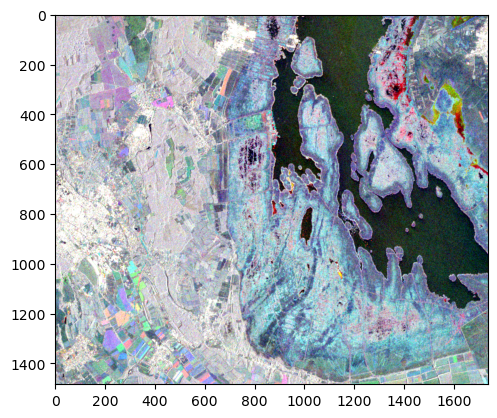

In [15]:
import matplotlib.pyplot as plt
plt.imshow(rgb_comp)

Besides a colourful representation of agricultural areas due to crop rotation, changes of the vegetation state of the reed belt (blueish border line around the water surface) and a dry-out of smaller ponds/swamps in the upper-right corner are clearly visible.